In [3]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("store.csv")
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [5]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [8]:
store_daily_sales = df.groupby(['date', 'store']).agg({'sales': 'sum'}).reset_index()
store_daily_sales

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032
...,...,...,...
18255,2017-12-31,6,2009
18256,2017-12-31,7,1831
18257,2017-12-31,8,3205
18258,2017-12-31,9,2774


In [9]:
filt = store_daily_sales['store'] == 1
store_1_df = store_daily_sales[filt]
store_1_df

,date,store,sales
0,2013-01-01,1,1316
10,2013-01-02,1,1264
20,2013-01-03,1,1305
30,2013-01-04,1,1452
40,2013-01-05,1,1499
...,...,...,...
18210,2017-12-27,1,1837
18220,2017-12-28,1,1951
18230,2017-12-29,1,2116
18240,2017-12-30,1,2304


In [10]:
store_1_df.set_index('date', inplace=True)
store_1_df

,store,sales
date,,
2013-01-01,1,1316
2013-01-02,1,1264
2013-01-03,1,1305
2013-01-04,1,1452
2013-01-05,1,1499
...,...,...
2017-12-27,1,1837
2017-12-28,1,1951
2017-12-29,1,2116


In [343]:
n_splits = 5
kf = KFold(n_splits=n_splits)

# Hàm để tính giá trị log-likelihood trung bình cho một số lượng trạng thái ẩn
def cross_val_score_hmm(n_states, data, n_splits=5):
    log_likelihoods = []
    
    for train_index, test_index in kf.split(data):
        train_data = data[train_index]
        test_data = data[test_index]
        
        model = GaussianHMM(n_components=n_states, covariance_type="full", random_state=42)
        model.fit(train_data)
        
        log_likelihood = model.score(test_data)
        log_likelihoods.append(log_likelihood)
    
    return np.mean(log_likelihoods)

mean_log_likelihoods = []

# Thử nghiệm với số lượng trạng thái ẩn từ 1 đến 10
for n_states in range(1, 11):
    mean_log_likelihood = cross_val_score_hmm(n_states, store_1_df['sales'].values.reshape(-1,1), n_splits)
    mean_log_likelihoods.append((n_states, mean_log_likelihood))

# Tìm số trạng thái ẩn tối ưu dựa trên log-likelihood trung bình
optimal_states = max(mean_log_likelihoods, key=lambda x: x[1])[0]

print(f"Số trạng thái ẩn tối ưu: {optimal_states}")


Số trạng thái ẩn tối ưu: 9


In [344]:
train_df = store_1_df[:-30]
test_df = store_1_df[-30:]
n_components_range = range(2, 11)
aics = []
for n_components in n_components_range:
    model = GaussianHMM(n_components=n_components, covariance_type="full", random_state=42)
    model.fit(train_df['sales'].values.reshape(-1,1))
    aics.append(model.aic(train_df['sales'].values.reshape(-1,1)))

# Chọn mô hình có AIC nhỏ nhất
best_n_components = n_components_range[np.argmin(aics)]
best_n_components

9

In [528]:
# store_1_df['sales'] = (store_1_df['sales'] - store_1_df['sales'].min()) / (store_1_df['sales'].max() - store_1_df['sales'].min())
train_df = store_1_df[:-30]
test_df = store_1_df[-30:]
model_hmm = GaussianHMM(n_components=best_n_components, covariance_type="full", random_state=42)
model_hmm.fit(train_df['sales'].values.reshape(-1,1))

predicted_prices = []
current_price = train_df['sales'].values[-1]

for _ in range(len(test_df)):
    # Dự đoán trạng thái ẩn cho giá trị hiện tại
    current_state = model_hmm.predict([[current_price]])[0]
    # Lấy giá trị trung bình của trạng thái hiện tại để làm dự đoán cho bước tiếp theo
    predicted_price = np.random.normal(model_hmm.means_[current_state][0], np.sqrt(model_hmm.covars_[current_state][0][0]))
    predicted_prices.append(predicted_price)
    # Cập nhật giá trị hiện tại
    current_price = predicted_price
print(predicted_prices)

[1760.1196730844244, 2185.438694324733, 1777.2758485318054, 1820.0614851923572, 1720.8353099379437, 1425.3781250161605, 1701.7368838986138, 1978.0950071729874, 1460.8145860459917, 1659.8723879260413, 1712.2704679006588, 1768.8523514062333, 1994.3848305257034, 1628.1960250943478, 2498.081941403966, 2084.737067666726, 2070.7673526082212, 1551.1689071268388, 1707.20723642697, 1478.869479345441, 1929.1006761440785, 1762.6552334224973, 1505.1979000402885, 1435.4994751602337, 2082.544298173067, 1999.6505678556819, 1692.3955003926, 1529.2795579239923, 2136.1620105794086, 1795.4230752965525]


In [96]:
y_test = np.array(test_df['sales'])
y_test

array([2170, 2418, 1510, 1829, 1841, 1984, 2139, 2255, 2391, 1681, 1811,
       1860, 1987, 2147, 2288, 2375, 1617, 1791, 1875, 2028, 2122, 2297,
       2384, 1576, 1843, 1837, 1951, 2116, 2304, 2388], dtype=int64)

In [529]:
y_pred = np.array(predicted_prices)
y_pred

array([1760.11967308, 2185.43869432, 1777.27584853, 1820.06148519,
       1720.83530994, 1425.37812502, 1701.7368839 , 1978.09500717,
       1460.81458605, 1659.87238793, 1712.2704679 , 1768.85235141,
       1994.38483053, 1628.19602509, 2498.0819414 , 2084.73706767,
       2070.76735261, 1551.16890713, 1707.20723643, 1478.86947935,
       1929.10067614, 1762.65523342, 1505.19790004, 1435.49947516,
       2082.54429817, 1999.65056786, 1692.39550039, 1529.27955792,
       2136.16201058, 1795.4230753 ])

In [530]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE:  397.97334171561096


In [531]:
print("MAE: ", mean_absolute_error(y_test, y_pred))

MAE:  321.4779240857442


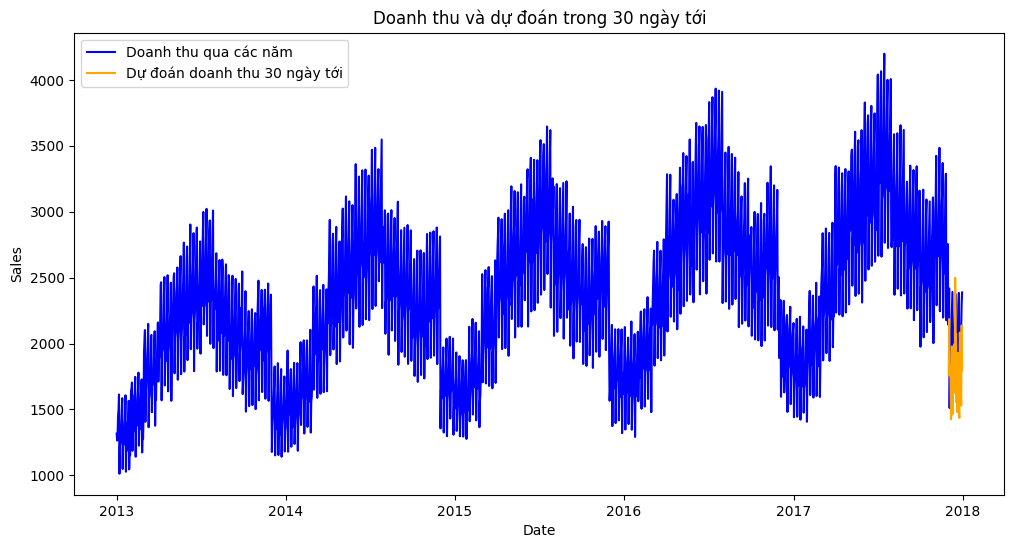

In [532]:
predicted_prices_df = pd.DataFrame(predicted_prices, index=test_df.index, columns=['predicted_sales'])

plt.figure(figsize=(12, 6))

plt.plot(store_1_df['sales'], label='Doanh thu qua các năm', color='blue')

plt.plot(predicted_prices_df['predicted_sales'], label='Dự đoán doanh thu 30 ngày tới', color='orange')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Doanh thu và dự đoán trong 30 ngày tới')
plt.legend()
plt.show()